In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy
import import_ipynb
import GP_util #load module first
import importlib
importlib.reload(GP_util) # reload full module
from GP_util import unique, select, fastdistancematrix,linear_pixel
#import methods from reloaded module

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


importing Jupyter notebook from GP_util.ipynb
importing Jupyter notebook from GP_util.ipynb


In [131]:
datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_24.csv'
df = pd.read_csv(datapath)

df = select(df, n=3000) # selects subset of df for time/memory reductions

In [132]:
f, df_unique, zero_farm_idx, Num_farms = unique(df)

there are 2050 unique farms in loaded df


In [133]:
distance, Dmatsq = fastdistancematrix(df, distance_calc=True)

In [16]:
with pm.Model() as GP_true:
    
    # ======  prior function   ========
    # ====== covariance matrix ========
    # ======        K          ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    l = pm.Gamma('l', alpha = 3, beta=.01)
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/l**2)+np.diag([sigmay]*Num_farms))
    
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
   
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, l, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [08:00<00:00,  4.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 3,6) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    lsq = pm.Gamma('lsq', alpha = 3.5, beta=1.2e-5)
    #l = pm.HalfCauchy('l', 100)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-1
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace_lsq = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, lsq, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [05:36<00:00,  5.36draws/s]
The acceptance probability does not match the target. It is 0.9010556400446182, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


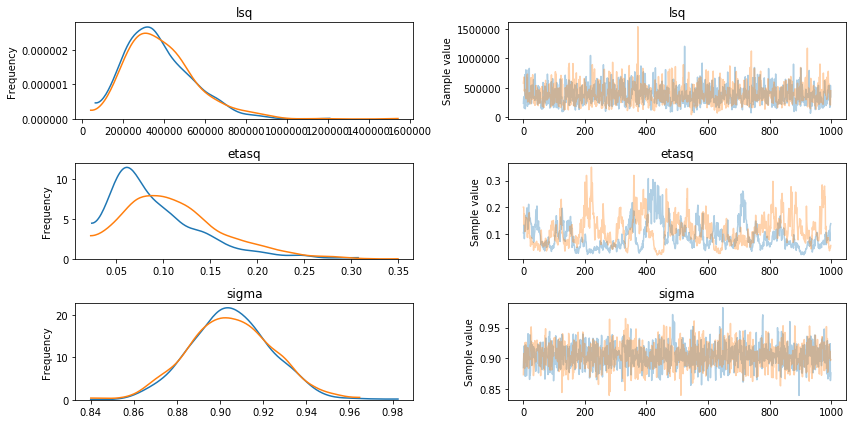

In [39]:
pm.traceplot(trace_lsq, varnames=['lsq','etasq','sigma']);

In [40]:
pm.summary(trace_lsq,varnames=['sigma','lsq','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.904791,0.019061,0.000504,0.867396,0.940828,1534.895247,0.999560
lsq,379587.629461,164211.482354,4540.131535,96987.180379,693846.328159,1219.531967,1.001744
etasq,0.103934,0.052880,0.004217,0.024194,0.208121,55.891474,1.036423


In [ ]:
with pm.Model() as GP_uncentered:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    trace_lsq = pm.sample(3000,chains=2,step=pm.Metropolis()) #nuts_kwargs={'target_accept': .95}

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [y_missing]
>Metropolis: [sigma]
>Metropolis: [a]
>Metropolis: [z]
>Metropolis: [lsq]
>Metropolis: [etasq]
Sampling 2 chains:   9%|▊         | 596/7000 [10:57<1:42:10,  1.04draws/s]

In [135]:
dlsq = pd.DataFrame(pm.summary(trace_lsq,varnames=['lsq','etasq']))
dlsq

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lsq,148713.351525,45567.822954,1954.404649,72687.616318,238141.735784,385.34090,1.003219
etasq,0.000282,0.000213,0.000013,0.000025,0.000724,150.44919,1.014791


In [ ]:
# the smaller I set sigma too, the smaller lsq gets
# also lower n_eff for both eta and ls

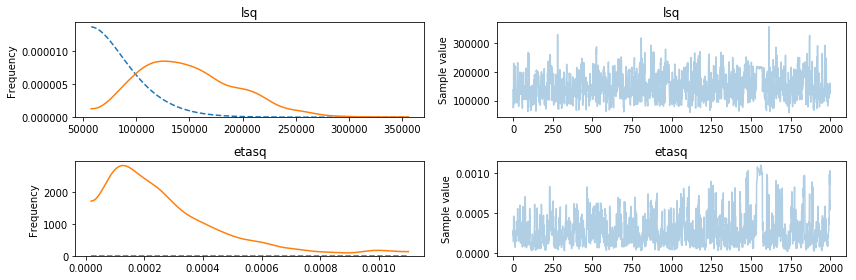

In [136]:

pm.traceplot(trace_lsq,varnames=['lsq','etasq'],priors=[lsq.distribution, etasq.distribution], 
             combined = True);

In [61]:
sns.kdeplot(trace_lsq['sigma'], trace_lsq['etasq'], s=2, alpha=.2);

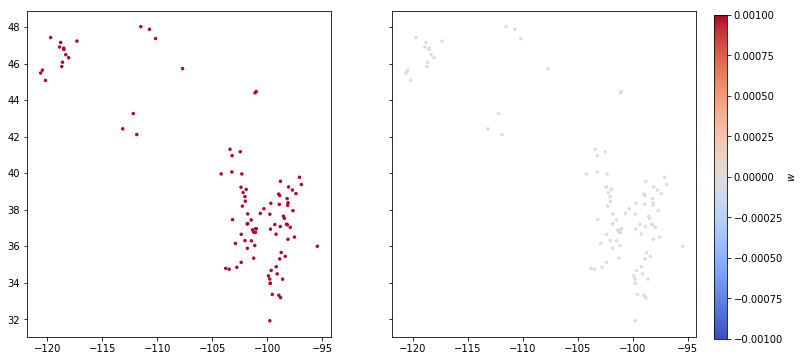

In [127]:
v = .001
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,6))
im = ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label='$w$');

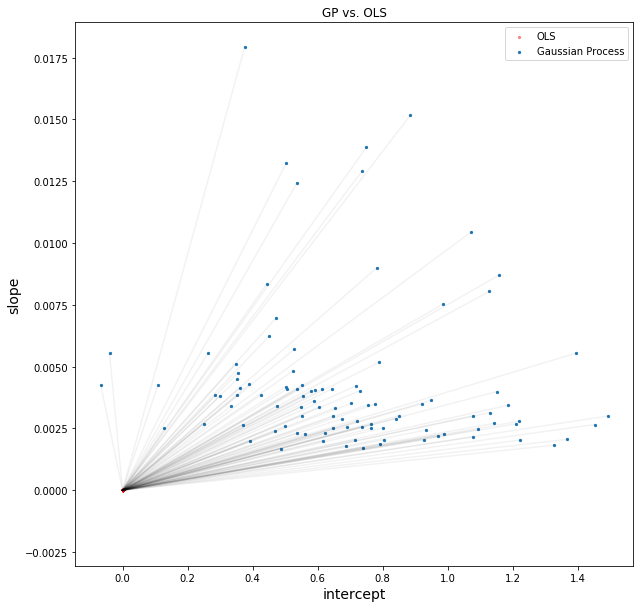

In [128]:
b1 = trace_lsq['w'].mean(axis=0)
a1 = trace_lsq['a'].mean(axis=0)

a2 = df_unique['a_zprsum3']
b2 = df_unique['B_zprsum3']

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(a0,b0,label='Ordinary Least Squares', s=10)
ax.scatter(a2, b2, label='OLS', c='r',s=5, alpha=.4)
ax.scatter(a1, b1, label='Gaussian Process', s=5, alpha=1)



#ax.plot([a1, a0], [b1, b0], 'k-', alpha=.05)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.05)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
ax.set_title('GP vs. OLS')
#ax.set_xlim(-.2,.2)
#ax.set_ylim(-1,1)
ax.legend();

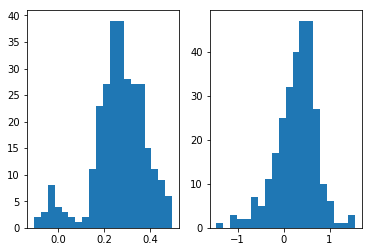

In [28]:
fig, ax = plt.subplots(1,2)
ax[0].hist(b1, 20)
ax[1].hist(b2, 20);

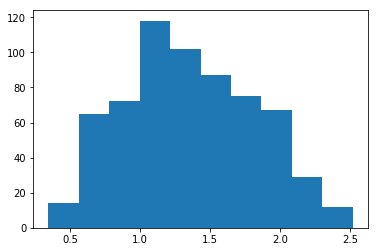

In [122]:
plt.hist(df.NDVIsum3);

5        1.137971
6        1.026795
7        1.001353
8        1.102994
9        1.201467
127      1.224160
128      1.730459
129      1.016523
130      1.626171
131      0.939615
132      1.739623
290      1.434489
291      1.294251
292      1.031895
293      1.634797
294      1.394372
295      1.132362
296      1.250369
297      1.254821
298      1.337760
979      1.501013
980      1.588261
981      2.517747
982      1.913164
983      2.053200
1046     1.526550
1047     1.058680
1048     0.511670
1049     0.925249
1050     1.365461
           ...   
22428    1.202214
22429    0.631937
22430    1.338480
22431    1.050219
22796    1.420010
22797    1.296999
22798    1.754535
22799    1.383531
22800    1.464899
23129    1.243729
23130    1.196771
23131    1.163951
23132    1.342538
23133    1.405771
23245    1.431192
23246    1.061228
23247    1.175800
23248    0.902491
23249    1.087775
23361    1.280913
23362    0.568369
23363    0.812094
23364    0.667231
23365    1.614091
23491    1

In [113]:
df_unique['B_zprsum3'] = 0
df_unique['a_zprsum3'] = 0
column_x='prsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='NDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]
    df_unique.loc[(df_unique.index == p),'a_' + column_x] = mu[0]

In [144]:
import scipy
Kij_sparse = scipy.sparse.csr_matrix(Kij)

In [145]:
Kij_sparse

<98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 9604 stored elements in Compressed Sparse Row format>

In [147]:
pm.sample?
